# Global alignment

The overall workflow for global alignment is very similar to that of a regular SPARXS experiment. For cluster analysis is identical to the first part of the single-molecule data analysis. The analysis needs to be performed untill the coordinates are found, as we only need these for performing the global alignment. As the clusters have different brightness, slightly different settings need to be used to find the coordinates. After that extracting sequencing data is identical. To perform global alignment, we obtain the tile mappings as before. However, the alingment method is different: instead of cross-correlation we now use geometric hashing. This gives the rotation and scaling factors for the combinations of fluorescence microscope and sequencer.

# 1. Cluster data analysis
The example dataset consists of images taken after sequencing on a MiSeq v3 flow cell consisting of 19 tiles. A Cy5-labeled probe was hybridized to the clusters containing the mapping sequence, therefore only these clusters have a bright intensity.
The flow cell was scanned with our fluorescence microscope, which has a field of view (FOV) of 32 x 64 μm, 
where we took steps of 30 and 62 μm. At each position a movie of 5-frames was taken using the red, 
642-nm laser, exciting Cy5.

In [1]:
from pathlib2 import Path
import papylio as pp
import matplotlib.pyplot as plt
import numpy as np
import matchpoint as mp
from skimage.transform import AffineTransform
import subprocess
import gzip

%matplotlib inline

## Experiment import

In [2]:
experiment_path = Path(r'C:\Users\user\Desktop\SPARXS example dataset')

In [3]:
exp = pp.Experiment(experiment_path)

Import files: 100%|██████████████████████████████████████████████████████████████| 4190/4190 [00:00<00:00, 6218.19it/s]



File(Single-molecule data - bead slide\Bead slide TIRF 561 001) used as mapping

Initialize experiment: 
C:\Users\user\Desktop\SPARXS example dataset


In [4]:
exp.files[0:10]

FileCollection([File(Cluster data for global alignment\TIRF 642 0001),
                File(Cluster data for global alignment\TIRF 642 0002),
                File(Cluster data for global alignment\TIRF 642 0003),
                File(Cluster data for global alignment\TIRF 642 0004),
                File(Cluster data for global alignment\TIRF 642 0005),
                File(Cluster data for global alignment\TIRF 642 0006),
                File(Cluster data for global alignment\TIRF 642 0007),
                File(Cluster data for global alignment\TIRF 642 0008),
                File(Cluster data for global alignment\TIRF 642 0009),
                File(Cluster data for global alignment\TIRF 642 0010)])


Set rotation parameter.
The software assumes two vertical channels (left Cy3 and right Cy5), however, the images have two horizontal channels. Therefore, the data obtained from the movie needs to be rotated counterclockwise 1 x 90 degrees, i.e. rot90 = 1. (Definition is the same as for numpy.rot90.)

In [5]:
exp.configuration['movie']['rot90'] = 1
exp.configuration.save()
exp.files.movie.rot90 = 1

All files are stored in the files attribute of the experiment.

In [6]:
exp.files[0:10]

FileCollection([File(Cluster data for global alignment\TIRF 642 0001),
                File(Cluster data for global alignment\TIRF 642 0002),
                File(Cluster data for global alignment\TIRF 642 0003),
                File(Cluster data for global alignment\TIRF 642 0004),
                File(Cluster data for global alignment\TIRF 642 0005),
                File(Cluster data for global alignment\TIRF 642 0006),
                File(Cluster data for global alignment\TIRF 642 0007),
                File(Cluster data for global alignment\TIRF 642 0008),
                File(Cluster data for global alignment\TIRF 642 0009),
                File(Cluster data for global alignment\TIRF 642 0010)])

Note: to import your own image files with correct metadata, you may need to adjust some of the python files in the movie folder of the traceAnalysis package. For tif files you need to adjust the `tif.py` file, where in the `_read_header` method an `elif` statement can be added for other metadata. For `.pma`, `.sifx` and `.nd2` files, processing files are already present. For other file types you can add additional python files, using the `tif.py` file as an example.

To allow handling the files images with the green laser and those with the red laser, before and after the main movie, we store them in separate variables. Additionally, we find the file that will be used for aligning the Cy3- and Cy5-emission channels.

To do this we use the select method, for which the first argument is the string that needs to be contained in the attribute given as the second argument.

In [7]:
files_cluster_data = exp.files.select('Cluster data for global alignment', 'relativePath')

Tell the software which files are obtained with the red laser (i.e. illuminations 0 and 1 correspond to green and red, respectively).

In [8]:
files_cluster_data[0:10].print()

  0.  Cluster data for global alignment\TIRF 642 0001
  1.  Cluster data for global alignment\TIRF 642 0002
  2.  Cluster data for global alignment\TIRF 642 0003
  3.  Cluster data for global alignment\TIRF 642 0004
  4.  Cluster data for global alignment\TIRF 642 0005
  5.  Cluster data for global alignment\TIRF 642 0006
  6.  Cluster data for global alignment\TIRF 642 0007
  7.  Cluster data for global alignment\TIRF 642 0008
  8.  Cluster data for global alignment\TIRF 642 0009
  9.  Cluster data for global alignment\TIRF 642 0010


Since for global alignment only a single channel is used, we don't need to perform channel alignment. However, since the software still expects an alignment we set it manually, with a translation of half the field of view. (Instead it would also be possible to do a regular channel alignment.)

In [9]:
files_cluster_data.mapping = mp.MatchPoint(source_name='Donor',
                                           destination_name='Acceptor',
                                           transformation={'translation': [256,0]})

## Find coordinates
Here the locations of the single-molecules are identified.

In [10]:
# files_cluster_data.get_projection_image(load=False, 
#                                        projection_type='average',
#                                        frame_range=(0, 10),
#                                        illumination=0) # For remaking the projection image

files_cluster_data.find_coordinates(channels=['acceptor'], 
                            method='by_channel',                                 # If only one channel, use 'by_channel'; If two channels, use 'sum_channels' or 'average_channels'.
                            projection_image=dict(projection_type='average',     # Choose average or maximum
                                                  frame_range=(0, 10),           # The range of frames to use, syntax similar to the range function, so [0, 20] represents the first 20 frames.
                                                  illumination=0),               # 0 corresponds to red illumination here (as no illumination is set)
                            peak_finding=dict(method='local-maximum',
                                              minimum_intensity_difference=45000,
                                              maximum_intensity_difference=1000000,
                                              filter_neighbourhood_size_min=10,
                                              filter_neighbourhood_size_max=10),
                            coordinate_optimization=dict(coordinates_within_margin=dict(
                                                            margin=5),           # Number of pixels to be fit with a gaussian to improve localization
                                                         coordinates_after_gaussian_fit=dict(
                                                            gaussian_width=11))   # Margin (number of pixels) from the edge to remove the points from.
                            )

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

Serial processing


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:27<00:00, 54.05it/s]


C:\Users\user\surfdrive\Promotie\Code\Python\papylio\papylio\file.py:197: UserWarning: Frame range exceeds available frames, used frame range (0, 10) instead
  warnings.warn(f'Frame range exceeds available frames, used frame range {configuration["frame_range"]} instead')


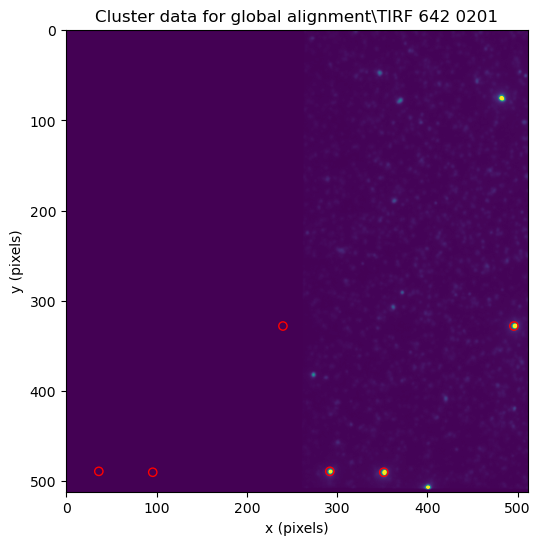

In [11]:
file_cluster = files_cluster_data[200]
fig, ax = plt.subplots(figsize=(6,6))
file_cluster.show_coordinates_in_image(vmin=0, vmax=4e4, figure=fig)

# 2. Sequence data analysis
Sequence analysis uses the fastq.gz files that are created by the sequencer as a starting point. These are compressed [fastq](https://en.wikipedia.org/wiki/FASTQ_format) text files containing the metadata (name, position, etc.), sequence and quality of each sequenced cluster. For our dataset we obtained two fastq files. Since global alignment is performed on a single sequencing tile, only two tiles are included in the sequencing dataset.

In [12]:
sequencing_data_path = (experiment_path / 'Sequencing data for global alignment').absolute()
sequencing_data_path

WindowsPath('C:/Users/user/Desktop/SPARXS example dataset/Sequencing data for global alignment')

## Create reference fasta file

A reference fasta file needs to be created containing the reference sequences. These are the sequences to which the sequencing data will be aligned and should thus contain the (general) sequences that are present in the sequenced sample. Below, the reference sequences are specified in a dictionary. The name of each reference sequence can be chosen by the user.

In [13]:
reference_sequences = {
    'CalSeq': 'CCAACAATGCCTAGCCGATCCGTAATGCCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGATCGGAAGAGCACACGTCTGAACTCCAGTCACAATGCCATCTCGTATGCCGTCTTCTGCTTG',
    'MapSeq': 'ACTGACTGTAACAACAACAACAATAACAACAACAACAATAACAACAACAACAAT',
    'HJ_general': 'CCCACCGCTCNNCTCAACTGGGTTTTCCCAGTTGAGNNCTTGCTAGGGTTTTCCCTAGCAAGNNGCTGCTACGGTTTTCCGTAGCAGCNNGAGCGGTGGG'
}

In [14]:
def create_reference_fasta(folder_path, reference_sequences):
    with open(Path(folder_path) / 'Reference.fasta', 'wt') as fasta_file:
        for key, value in reference_sequences.items():
            fasta_file.write('>' + key + '\n' + value + '\n\n')

In [15]:
create_reference_fasta(sequencing_data_path, reference_sequences)

## Merge fastq files

When using or configuring index reads, the sequencer may produce multiple fastq files.
You can combine these into a single file.

In [16]:
def merge_gz_files(input_files, output_file):
    with open(output_file, 'wt') as file_out:
        for input_file in input_files:
            with gzip.open(input_file, 'rt') as file_in:
                for line in file_in:
                    file_out.write(line)

In [17]:
list(sequencing_data_path.glob('*_R1_001.fastq.gz'))

[WindowsPath('C:/Users/user/Desktop/SPARXS example dataset/Sequencing data for global alignment/Empty_S1_L001_R1_001.fastq.gz'),
 WindowsPath('C:/Users/user/Desktop/SPARXS example dataset/Sequencing data for global alignment/Undetermined_S0_L001_R1_001.fastq.gz')]

In [18]:
merge_gz_files(sequencing_data_path.glob('*_R1_001.fastq.gz'), sequencing_data_path / 'Read1.fastq')

## Run aligner
Sequence alignment was performed using bowtie 2.5.3.

To start using bowtie2, download and unzip the bowtie2 binaries from [Sourceforge](https://sourceforge.net/projects/bowtie-bio/files/bowtie2/), as explained in the [bowtie2 manual](https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml).

The steps below run several bowtie2 commands that can be run in the terminal or command prompt.

We found that on Windows, it was neccesary to replace line 118 of bowtie2-build file by
`if not (os.path.exists(build_bin_spec) | os.path.exists(build_bin_spec + '.exe')):`


In [19]:
# Specify the location of Bowtie2
bowtie2_path = r"C:\Users\user\Desktop\bowtie2-2.5.3-mingw-aarch64"

In [20]:
# Assuming the use of a conda environment named "papylio"
subprocess.run("conda activate papylio".split(' '), shell=True, capture_output=True) 

CompletedProcess(args=['conda', 'activate', 'papylio'], returncode=0, stdout=b'', stderr=b'')

The following line runs bowtie2-build. For more information about the settings, see the [bowtie2 manual](https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml)

In [21]:
out = subprocess.run(
    [
        'python', bowtie2_path + r'\bowtie2-build', 
        "--quiet",
        "Reference.fasta", 
        "Reference"
    ], 
    cwd=str(sequencing_data_path.absolute()), 
    shell=True, 
    capture_output=True)

print(out.stderr.decode())
print(out.stdout.decode())


C:\Users\user\Desktop\bowtie2-2.5.3-mingw-aarch64\bowtie2-build-s



The following line runs the bowtie2 aligner. 

In [22]:
out = subprocess.run(
    [
        bowtie2_path + r'\bowtie2',
        '-x', 'Reference',
        '-U', 'Read1.fastq',
        '-S', 'Alignment.sam',
        '--local',
        '--np', '0',
        '--very-sensitive-local',
        '-L', '7',
        '--n-ceil', 'L,0,1',
        '--threads 10',
        '--norc',
    ],
    cwd=str(sequencing_data_path.absolute()), 
    shell=True, 
    capture_output=True)

print(out.stderr.decode())
print(out.stdout.decode())

549751 reads; of these:
  549751 (100.00%) were unpaired; of these:
    1632 (0.30%) aligned 0 times
    511887 (93.11%) aligned exactly 1 time
    36232 (6.59%) aligned >1 times
99.70% overall alignment rate




The “local” setting allows soft clipping of the ends of the reads. The “very-sensitive-local” setting may be a good place to start. 
The “norc” setting will prevent alignment to the reverse complement of the reference. Depending on the length of the sequence region that is identical among similar samples, the seed length for searching will need to be adjusted using the “L” setting. If the reference contains “N”s then it is important to set “np” and “n-ceil” options. Currently out of all degenerate base codes only “N”s are supported by Bowtie 2. In addition, the “score-min” option may be used to change the threshold for including alignments. 

For more information about the settings, see the [bowtie2 manual](https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml)

Bowtie2 produces a file with the [SAM file format](https://en.wikipedia.org/wiki/SAM_(file_format)), with the name Alignment.sam. This file contains all orginal sequences and information on how this sequence is best aligned in the form of a [CIGAR string](https://en.wikipedia.org/wiki/Sequence_alignment#Representations).

## Import sequencing data into experiment

Retreiving specific data from the text-based SAM file is relatively slow. Additionally the SAM file only states how to align the sequence but does not contain the actual aligned sequence. Therefore, we convert the SAM file to a NetCDF file for fast data retrieval and to enable inclusion of the actual aligned sequence.

In [23]:
aligned_sam_filepath = sequencing_data_path.joinpath('Alignment.sam')
index1_fastq_filepath = None # If the index1 was sequenced as well, specify the path to the fastq file to import it into the sequencing data.
extract_sequence_subset = None # Positions in the sequence to be separately extracted for easy lookup

exp.import_sequencing_data(aligned_sam_filepath, index1_file_path=index1_fastq_filepath, remove_duplicates=True,
                           add_aligned_sequence=True, extract_sequence_subset=extract_sequence_subset)

Determine number of primary alignments: 549756it [00:01, 320535.93it/s]
Parse sam file: 100%|██████████████████████████████████████████████████████████████████| 55/55 [00:32<00:00,  1.70it/s]


Arguments:
- `remove_duplicates`: Depending on the configuration for bowtie2 the SAM file can contain multiple alignments for a single sequence. These can cause problems later on in the analysis. If set to `True` (recommended), duplicate alignments will be removed and only the best alignment will be kept.
- `add_aligned_sequence`: If set to `True` (recommended), the aligned sequence will be added in the dataset.
- `extract_sequence_subset`: A subset of the aligned sequence can be added as a separate entry in the dataset, which is useful to easily distinguish the sequences. The variable can be set to the indexes in the sequence to be used.

# 3. Globally aligning datasets

## Generate tile alignment files

In [24]:
mapping_sequence_name = 'MapSeq'

exp.generate_tile_mappings(files_cluster_data, 
                           mapping_sequence_name=mapping_sequence_name, 
                           surface=0,
                           name='Cluster data')

Make tile mappings: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.76it/s]


## Perform global alignment

In [25]:
mapping = exp.tile_mappings[exp.tile_mappings.name.regex('Cluster data')][0]

C:\Users\user\miniconda3\envs\trace_analysis\lib\site-packages\objectlist\base.py:214: FutureWarning: The input object of type 'MatchPoint' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'MatchPoint', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return type(self)(np.array(self.data)[item].tolist(), **self.dict_without_data)
C:\Users\user\miniconda3\envs\trace_analysis\lib\site-packages\objectlist\base.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return type(se

As it is usually not known whether the datasets are mirrored or not, it is necessary to try both cases. First we try the case without mirroring.

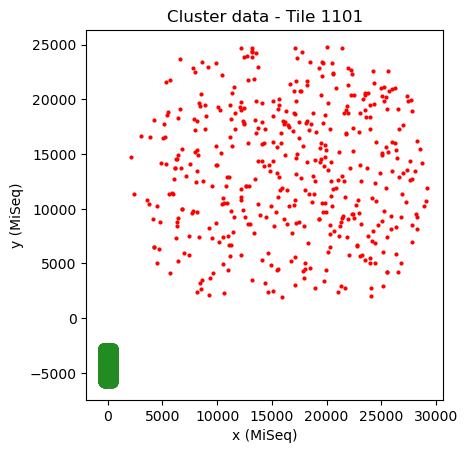

In [26]:
# Use "%matplotlib qt" to open in a seprate window for closer examination.
mapping.transformation = AffineTransform(scale=[1, 1]) # Reset transformation
mapping.show()

In [27]:
# Incorrect alignment
mapping.geometric_hashing(method='abundant_transformations', tuple_size=4, maximum_distance_source=50,
                          maximum_distance_destination=2500, plot=False, chunksize=1000000, parameters=['translation', 'rotation', 'scale'])

Source chunks: 1it [00:00,  4.05it/s]


In [28]:
mapping.transformation

<AffineTransform(matrix=
    [[ 5.48940651e+01, -2.35825410e+01,  1.54290761e+04],
     [ 2.35825410e+01,  5.48940651e+01,  1.09823925e+04],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x289079a3f10>

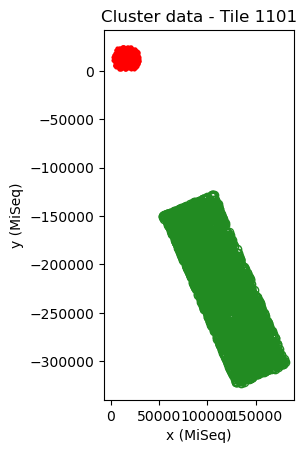

In [29]:
mapping.show()

Here, the alignment is incorrect. This can be seen from the strange translation, rotation and scaling of the sequencing tile with respect to the cluster fluorescence data, i.e. the sequencing data (red) is located outside the cluster data (green), the width of the two datasets are not similar and the angle is not a multiple of ~90 degrees (which should be the case if the proper region of the tile is scanned). In addition, only few points overlap well, which should not be the case for cluster data that has a low fractuib of missing points.

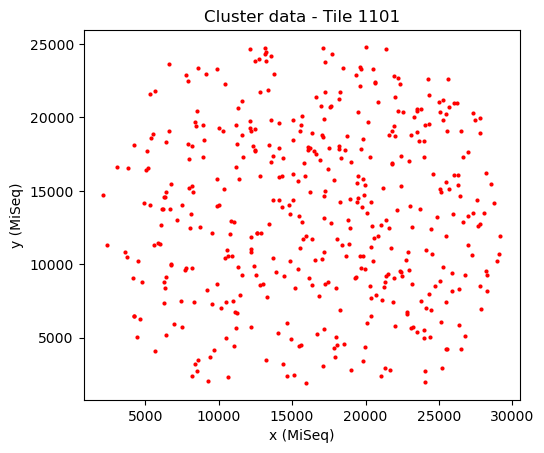

In [30]:
mapping.show(crop='source')

Now we start alignment with a mirrored transformation. We do this by setting one of the two dimensions of `scale` to `-1`. 

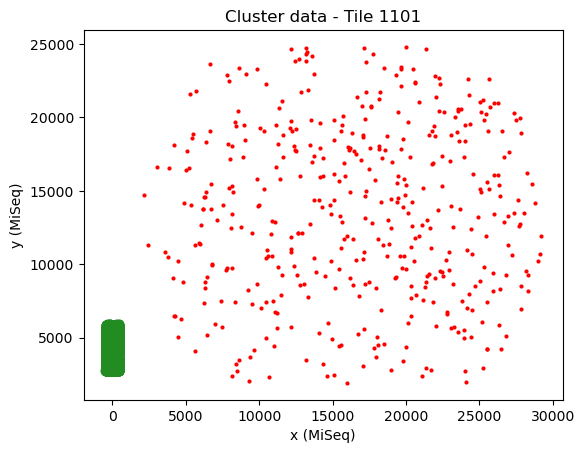

In [31]:
mapping.transformation = AffineTransform(scale=[1, -1])
mapping.show()

In [32]:
mapping.scale

array([1., 1.])

In [33]:
mapping.transformation.shear

-3.141592653589793

In [34]:
# Correct alignment
mapping.geometric_hashing(method='abundant_transformations', tuple_size=4, maximum_distance_source=50,
                          maximum_distance_destination=2500, plot=False, chunksize=1000000, parameters=['translation', 'rotation', 'scale'])

Source chunks: 1it [00:00,  7.23it/s]


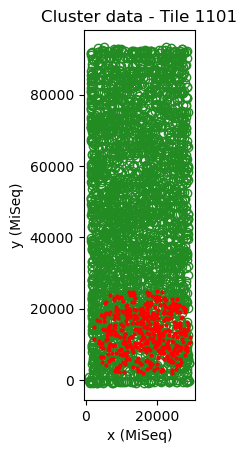

In [35]:
mapping.show()

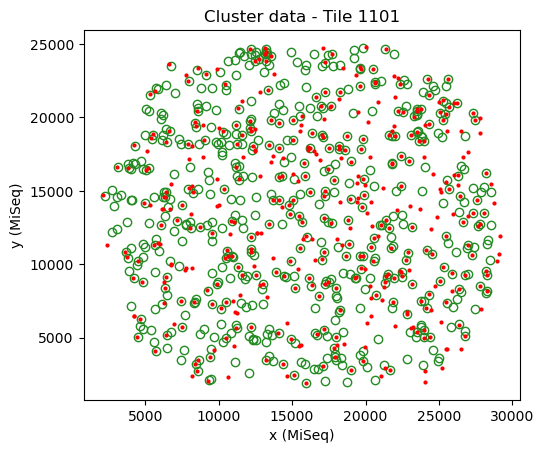

In [36]:
mapping.show(crop='source')

Here, the sequencing data (red) has a similar width as the cluster data (green) and the angle is a multiple of ~90 degrees. In addition, a large fraction of the points overlap well.

The rotation and scaling parameters can be used for subsequent experiments using the combination of sequencer and fluorescence microscope.

In [37]:
print('Rotation:', mapping.rotation)
print('Scaling:', '[', mapping.scale[0], -mapping.scale[1]*np.sign(mapping.shear+0.00001) ,']')

Rotation: 0.004010402492158897
Scaling: [ 29.438597863994918 29.438597863994918 ]


In [38]:
np.sign(mapping.shear)

-1.0